In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mcpdf.nnpdf import data, defaults, theory

%matplotlib inline

In [2]:
# datasets

datasets_list = [
    {'dataset': 'NMCPD_dw_ite', 'frac': 0.75},
    {'dataset': 'NMC', 'frac': 0.75},
    {'dataset': 'SLACP_dwsh', 'frac': 0.75},
    {'dataset': 'SLACD_dw_ite', 'frac': 0.75},
    {'dataset': 'BCDMSP_dwsh', 'frac': 0.75},
    {'dataset': 'BCDMSD_dw_ite', 'frac': 0.75},
    {'dataset': 'CHORUSNUPb_dw_ite', 'frac': 0.75},
    {'dataset': 'CHORUSNBPb_dw_ite', 'frac': 0.75},
    {'dataset': 'NTVNUDMNFe_dw_ite', 'frac': 0.75},
    {'dataset': 'NTVNBDMNFe_dw_ite', 'frac': 0.75},
    {'dataset': 'HERACOMBNCEM', 'frac': 0.75},
    {'dataset': 'HERACOMBNCEP460', 'frac': 0.75},
    {'dataset': 'HERACOMBNCEP575', 'frac': 0.75},
    {'dataset': 'HERACOMBNCEP820', 'frac': 0.75},
    {'dataset': 'HERACOMBNCEP920', 'frac': 0.75},
    {'dataset': 'HERACOMBCCEM', 'frac': 0.75},
    {'dataset': 'HERACOMBCCEP', 'frac': 0.75},
    {'dataset': 'HERACOMB_SIGMARED_B', 'frac': 0.75},
    {'dataset': 'HERACOMB_SIGMARED_C', 'frac': 0.75}
]

ndatasets = len(datasets_list)

# load data and covmat for all the dataset
y = data.values(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)
cov = data.covmat(fit=defaults.BASELINE_PDF, dataset_inputs=datasets_list)

In [3]:
# load fk tables
fks = theory.theory(dataset_inputs=[ds['dataset'] for ds in datasets_list])


-- Reading COMMONDATA for Dataset: NMCPD_dw_ite
nData: 260 nSys: 105
-- COMMONDATA Files for NMCPD_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: NMC
nData: 292 nSys: 16
-- COMMONDATA Files for NMC successfully read.


-- Reading COMMONDATA for Dataset: SLACP_dwsh
nData: 211 nSys: 3
-- COMMONDATA Files for SLACP_dwsh successfully read.


-- Reading COMMONDATA for Dataset: SLACD_dw_ite
nData: 211 nSys: 103
-- COMMONDATA Files for SLACD_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: BCDMSP_dwsh
nData: 351 nSys: 11
-- COMMONDATA Files for BCDMSP_dwsh successfully read.


-- Reading COMMONDATA for Dataset: BCDMSD_dw_ite
nData: 254 nSys: 108
-- COMMONDATA Files for BCDMSD_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: CHORUSNUPb_dw_ite
nData: 607 nSys: 1014
-- COMMONDATA Files for CHORUSNUPb_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: CHORUSNBPb_dw_ite
nData: 607 nSys: 114
-- COMMONDATA Files for CHORUSNBPb_dw_ite successfu

In [4]:
# look at the flavors of loaded fk tables and build the corresponding boolean mask
# assume some grid dimension for this

# possible flavors appearing in the FK tables
flavs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
nxgrid = 40
mask_list=[]

for fk in fks:
    mask = [flav in fk.elements[0].flavors for flav in flavs for k in range(0,nxgrid)]
    mask_list.append(mask)

In [5]:
# now build the corresponding matrices

matrix_list = []
for m in mask_list:
    matrix = []
    for pos, i in enumerate(m):
        if i:
            tmp = np.zeros(len(flavs)*nxgrid)
            tmp[pos]=1.
            matrix.append(tmp)
    
    matrix_list.append(np.array(matrix))

In [6]:
### define a common xgrid
newgrid = np.geomspace(1e-6, 1., nxgrid)
for fk in fks:
    fk.x_reshape(newgrid)

In [7]:
# reshape the fk tables to matrices 
fk_bare_list = []
for fk in fks:
    ndata, nbasis, nx = fk.elements[0].table.shape
    fk_bare_list.append(np.reshape(fk.elements[0].table,(ndata,nbasis*nx)))

In [8]:
# multiply fk for the matrix
reshaped_fk = []

for fk_bare, matrix in zip(fk_bare_list, matrix_list):
    reshaped_fk.append(fk_bare @ matrix)

In [9]:
fk_bare = np.concatenate([fk for fk in reshaped_fk], axis=0)
fk_bare.shape

(3089, 560)

In [10]:
fk = fk_bare

In [11]:
def distinfo(values):
    print(f"   max = {max(values)}",
          f"   min = {min(values)}",
          f"absmin = {min(abs(values))}",
          sep = "\n")

    sns.boxenplot(x=values, scale="exponential")
    plt.xscale("log")

   max = 308.3964848735588
   min = 1.838395290266506e-07
absmin = 1.838395290266506e-07


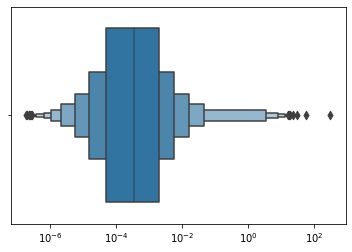

In [12]:
# diagonalize experimental covmat and check its eigenvalues
l, u = np.linalg.eig(cov)
distinfo(l)

In [13]:
# compute inverse of the posterior covmat according to Eq.46
v = u.T@fk
posterior_cov_inverse = v.T @ np.diag(1./l) @ v

In [14]:
posterior_cov_inverse.shape

(560, 560)

In [15]:
# add a gaussian prior proportional to the identity to regularize
_, N = posterior_cov_inverse.shape
posterior_cov_inverse_prior = posterior_cov_inverse + 0.0001*np.identity(N)

   max = 214000.03488934276
   min = -4.760300157530312e-13
absmin = 0.0


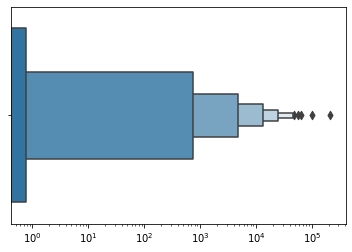

In [16]:
# check eigenvalues without prior
ll, uu = np.linalg.eig(posterior_cov_inverse)
distinfo(np.real(ll))

   max = 214000.03498934244
   min = 9.999999941440967e-05
absmin = 9.999999941440967e-05


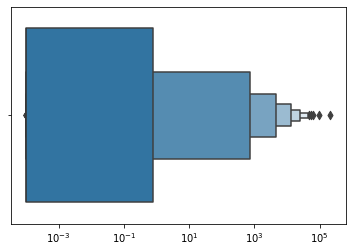

In [17]:
# check eigenvalues with prior
llp, uup = np.linalg.eig(posterior_cov_inverse_prior)
llp = np.real(llp)
uup = np.real(uup)
distinfo(llp)

In [18]:
# posterior covmat
cov_posterior = uup @ np.diag(1./llp) @ uup.T

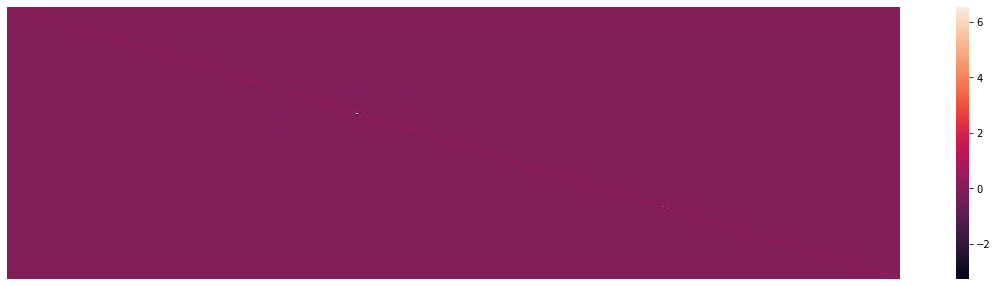

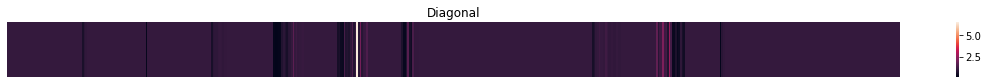

In [19]:
id_test = posterior_cov_inverse_prior @ cov_posterior
plt.figure(figsize=(20,5))
sns.heatmap(id_test, xticklabels=False, yticklabels=False)
plt.figure(figsize=(20, 1))
plt.title("Diagonal")
sns.heatmap(np.diag(id_test)[np.newaxis,:], xticklabels=False, yticklabels=False);

In [20]:
# compute central value posterior, Eq. 47
v1 = u.T@y
w = uup.T@fk.T@ u
cv_posterior = uup @ np.diag(1./llp) @ w @ np.diag(1./l) @ v1

In [21]:
cv_posterior.shape

(560,)

In [22]:
# draw samples
samples=np.random.multivariate_normal(cv_posterior, cov_posterior, size=1000)

In [23]:
samples.shape

(1000, 560)

In [24]:
f = np.array([samples[:,i*nxgrid:(i+1)*nxgrid] for i in range(0,len(flavs))])
flavour_cv = f.mean(axis=1)
flavour_std = f.std(axis=1)
    
flavour_labels=np.array(['photon','Sigma','g','V','V3','V8','V15','V24','V35','T3','T8','T15','T24','T35'])

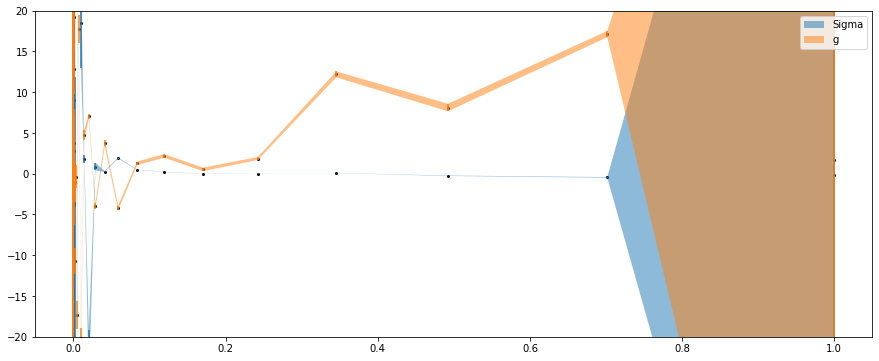

In [25]:
flavs_to_plots = [1,2]
plot_mask = np.array([flav in flavs_to_plots for flav in flavs])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

for i in range(0,len(flavs_to_plots)):
    plt.scatter(newgrid,flavour_cv[plot_mask][i],c='black',s=4)
    plt.errorbar(newgrid,flavour_cv[plot_mask][i],yerr=[flavour_std[plot_mask][i],flavour_std[plot_mask][i]],linestyle='None')
    plt.fill_between(newgrid, flavour_cv[plot_mask][i]-flavour_std[plot_mask][i], 
                     flavour_cv[plot_mask][i]+flavour_std[plot_mask][i], label=flavour_labels[plot_mask][i],alpha=0.5)
plt.xscale('linear')
plt.ylim(-20,20)
plt.legend()